# **Team 8: the 3rd Bulgarian empire - Iteration 1 Notebook**

In [163]:
# General & data preparation
import pandas as pd
from collections import Counter
import re

# Data vizualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model & evaluation
import sklearn as scikit_learn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

## **DATA UNDERSTANDING**

In [142]:
# Load the dataset
file_path = "Data/set8_it1.csv"
df = pd.read_csv(file_path)

In [143]:
# We drop the DI column and explore the dataset for any obvious inconsistencies
df = df.drop(["DI"], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TradeValue      2363 non-null   float64
 1   RealmType       2363 non-null   object 
 2   Enclave         2363 non-null   object 
 3   LivingQuarters  2244 non-null   float64
 4   ParcelSize      2363 non-null   float64
 5   ParcelSizeUnit  2363 non-null   object 
dtypes: float64(3), object(3)
memory usage: 110.9+ KB


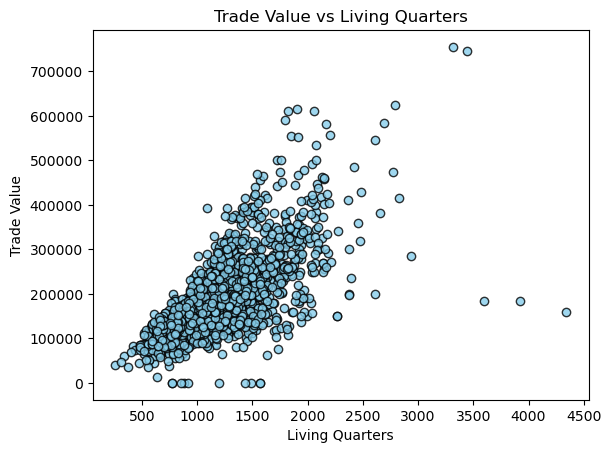

In [144]:
# Scarrerplot
plt.scatter(df['LivingQuarters'].loc[df['LivingQuarters'] != ''], df['TradeValue'], color='skyblue', edgecolor='black', alpha=0.8)
 
# Add labels and title
plt.xlabel('Living Quarters')
plt.ylabel('Trade Value')
plt.title('Trade Value vs Living Quarters')
 
# Show the plot
plt.show()

C:\Users\silve\AppData\Local\Temp\ipykernel_4024\2568822356.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=groups.index, patch_artist=True, boxprops=dict(facecolor='skyblue', color='black'), whiskerprops=dict(color='black'), showfliers=False)


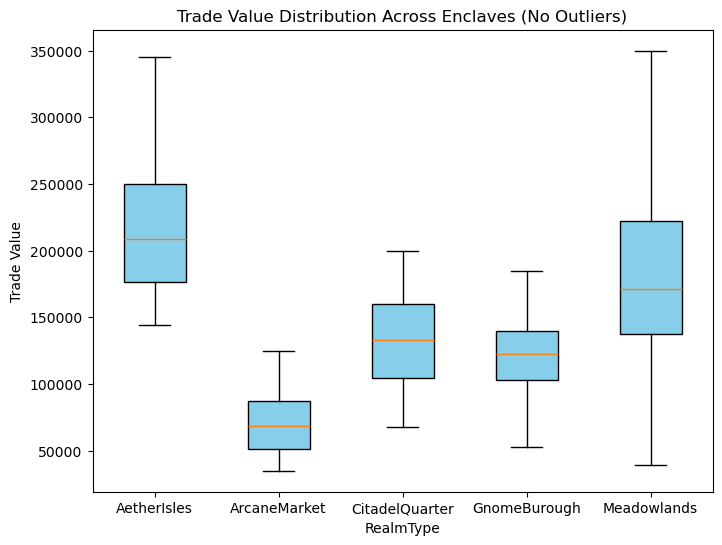

In [145]:
# Boxplot
groups = df.groupby('RealmType')['TradeValue'].apply(list) # Create the boxplot without outliers

plt.figure(figsize=(8, 6))
plt.boxplot(groups, labels=groups.index, patch_artist=True, boxprops=dict(facecolor='skyblue', color='black'), whiskerprops=dict(color='black'), showfliers=False)

# Hides outliers

# Add labels and title
plt.xlabel('RealmType')
plt.ylabel('Trade Value')
plt.title('Trade Value Distribution Across Enclaves (No Outliers)')

# Show the plot
plt.show()

## **DATA PREPARATION**

In [146]:
# Remove negative values in ParcelSize
df = df[df["ParcelSize"] >= 0]

# Remove rows with missing LivingQuarters data
df = df.dropna(subset=["LivingQuarters"])

# Remove rows where ParcelSize is less than 1
df = df[df["ParcelSize"] >= 1]

# Remove duplicate rows
df = df.drop_duplicates()

In [147]:
# Standardize Enclave column (strip spaces and fix casing)
df["Enclave"] = df["Enclave"].str.strip()

# Fix inconsistent enclave names
def standardize_enclave(enclave_series):
    enclave_counts = Counter(enclave_series)
    mapping = {}
    standardized_names = {}

    for enclave in enclave_counts:
        # Convert to a standard form: Capitalize 1st letter, remove the trailing 's' if it is present in the Enclave
        standardized = re.sub(r's$', '', enclave, flags=re.IGNORECASE).capitalize()

        # Keep track of the most frequent correct version
        if standardized not in standardized_names or enclave_counts[enclave] > enclave_counts.get(
                standardized_names[standardized], 0):
            standardized_names[standardized] = enclave

    # Replace variations with the most frequent correct version
    for enclave in enclave_series:
        standardized = re.sub(r's$', '', enclave, flags=re.IGNORECASE).capitalize()
        if standardized in standardized_names:
            mapping[enclave] = standardized_names[standardized]

    return enclave_series.replace(mapping)


df["Enclave"] = standardize_enclave(df["Enclave"])

In [148]:
# Convert ParcelSize to sqft if it is in sqm
conversion_factor = 10.7639  # 1 sqm = 10.7639 sqft
df.loc[df["ParcelSizeUnit"] == "sqm", "ParcelSize"] *= conversion_factor
df.loc[df["ParcelSizeUnit"] == "sqm", "ParcelSizeUnit"] = "sqft"

In [149]:
# Detect outliers using 1.5*IQR method
def detect_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

outliers_trade_value = detect_outliers("TradeValue")
outliers_living_quarters = detect_outliers("LivingQuarters")
outliers_parcel_size = detect_outliers("ParcelSize")

# Get index values of all outliers
outlier_indices = (
    outliers_trade_value.index.to_list() + 
    outliers_living_quarters.index.to_list() + 
    outliers_parcel_size.index.to_list()
)

# Drop these rows from the dataset
df = df.drop(index=outlier_indices)

In [150]:
# Check the amount of rows we have left and if there are any null left values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1987 entries, 0 to 2362
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TradeValue      1987 non-null   float64
 1   RealmType       1987 non-null   object 
 2   Enclave         1987 non-null   object 
 3   LivingQuarters  1987 non-null   float64
 4   ParcelSize      1987 non-null   float64
 5   ParcelSizeUnit  1987 non-null   object 
dtypes: float64(3), object(3)
memory usage: 108.7+ KB


### **Trends**

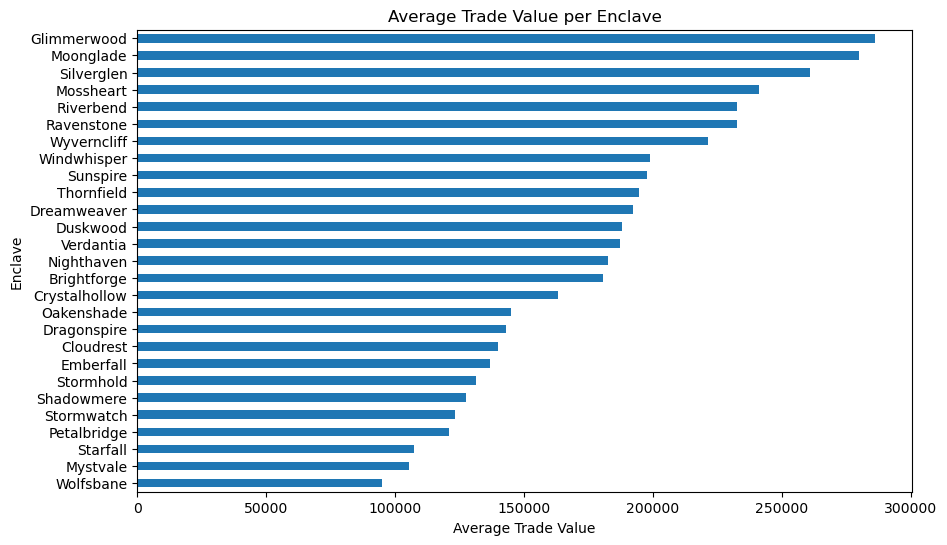

In [151]:
df2.groupby("Enclave")["TradeValue"].mean().sort_values().plot(kind="barh", figsize=(10, 6))
plt.xlabel("Average Trade Value")
plt.ylabel("Enclave")
plt.title("Average Trade Value per Enclave")
plt.show()

In [152]:
# We are transforming the categorical data into numerical using the label encoder
label_encoder_realm = LabelEncoder()
label_encoder_enclave = LabelEncoder()
df['RealmType'] = label_encoder_realm.fit_transform(df['RealmType'])
df['Enclave'] = label_encoder_enclave.fit_transform(df['Enclave'])

In [153]:
df2 = df.copy()
df2 = df2.drop(columns=["ParcelSizeUnit"])

In [154]:
# We check the correlation between the different values, to base our model on
df2.corr()

,TradeValue,RealmType,Enclave,LivingQuarters,ParcelSize
TradeValue,1.000000,0.024840,0.177668,0.664547,0.346667
RealmType,0.024840,1.000000,-0.418881,0.021536,0.343339
Enclave,0.177668,-0.418881,1.000000,0.097467,-0.172837
LivingQuarters,0.664547,0.021536,0.097467,1.000000,0.324557
ParcelSize,0.346667,0.343339,-0.172837,0.324557,1.000000


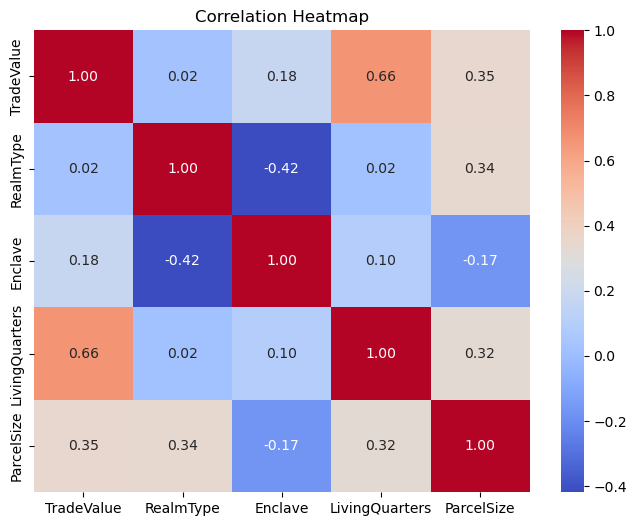

In [155]:
# Visualize the correlation with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df2.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

## **MODELING**

In [156]:
# The next step is to connect the prepared data from above and to use it for getting the mean and median of the TradeValue variable. 
mean_trade_value = df['TradeValue'].mean()
median_trade_value = df['TradeValue'].median()

In [157]:
# After that we separate our data into 2 categories: categorical data, which we transform and data we want to predict. They are separated in X, y respectively
X = df.drop(['TradeValue', 'ParcelSizeUnit'], axis=1)
y = df['TradeValue']

In [158]:
# Assign the data (80% of the data for training)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

# Fit in the data and trained it to make predictions
value = y_train.median()
pred_train = [value] * len(y_train)
pred_test = [value] * len(y_test)

## **EVALUATION**

In [159]:
# After the predictions we are using metrics such as Mean Absolute Error and Mean squared error to see what the efficiency of our model is
mae = mean_absolute_error(y_test, pred_test) 
mse = mean_squared_error(y_test, pred_test)

In [160]:
print("The MAE is", mae)
print("The MAPE is", mean_absolute_percentage_error(y_test, pred_test))
print("The MSE is", mse)

The MAE is 46365.547738693465
The MAPE is 0.2905738623754099
The MSE is 3699215675.708543
